(Model_Selection)=
# Model selection

Model selection consists in selecting the prediction model that is expected to provide the best performances on future data. The standard methodology consists of four main steps {cite}`bontempi2021statistical,bishop2006pattern,friedman2001elements`:

1. Define a collection of candidate models to be tested. Let $M$ be the number of models, and $h_k$, $1 \le k \le M$, be the $k-$th model in the collection, parameterized by a set of parameters $\theta_k$ (also see section [Baseline methodology - Supervised learning](ML_For_CCFD_Baseline_Methodology)). Given a class of models (such as decision trees, logistic regression, ...), a common practice is to define a collection of models of increasing complexity (tree depth for decision trees, regularisation coefficients for logistic regression, ...).  
2. Train each candidate model using the training data. The training of model $h_k$ identifies the parameters $\theta_k$ that maximizes the performances of $h_k$ on the training set.
3. Assess the performances of each candidate model by means of a validation procedure (see section [Validation Strategies](Validation_Strategies)). The validation procedure provides an estimate of the generalization performance. Let us denote by $A_{valid}(h_k(.,\theta_k))$ the validation performance for the $k$-th model. 
4. Select the model that has the highest validation performance. Denoting by $k^*$ the index of this optimal model, we have:

$$
k^*= \mathrm{arg\ max}_{k \in \{1,2,...,M\}} A_{valid(h_k(.,\theta_k))}
$$

An illustration of the model selection procedure with its different steps is provided in Fig. 1. 

![alt text](images/model_selection.png)
<div align="center">Fig. 1. Model selection procedure: A set of models of increasing complexity are trained, and their performances are assessed using a validation procedure. The model that provides the best validation performance is selected.</div>

The rationale for assessing models of increasing complexity is that there is usually a trade-off between the model complexity and its generalization performances (also referred to as the *bias/variance trade-off*) {cite}`bontempi2021statistical,bishop2006pattern,friedman2001elements`. Models that have too few parameters fail to properly represent the relationship between input and output features (also referred to as *underfitting*). Models that have many parameters can perfectly represent the relationship between input and output features in the training data (also referred to as *overfitting*). Training data are however often noisy, and their distribution slightly different from the validation and test data. As a result, overfitting is usually detrimental to the performances on the validation or test data. 

A qualitative representation of the trade-off between model complexity and performances is illustrated in Fig. 2. The training performances usually increase with the model complexity. The optimal validation and test performances are found for models of intermediate complexity, that both avoid underfitting and overfitting. This trade-off was experimentally illustrated with decision trees in the previous section on [Validation Strategies](Validation_Strategies).

![alt text](images/model_selection_graph.png)
<div align="center">Fig. 2. Trade-off between model complexity and performances. The optimal validation and test performances are usually found for models of intermediate complexity, that both avoid underfitting and overfitting. </div>

This section aims at refining the [sklearn validation pipeline](Sklearn_Validation_Pipeline), and exploring the trade-offs between model complexity and performances for different classes of models. 


In [65]:
# Initialization: Load shared functions and simulated data 

# Load shared functions
!curl -O https://raw.githubusercontent.com/Fraud-Detection-Handbook/fraud-detection-handbook/main/Chapter_References/shared_functions.py
%run shared_functions.py

# Get simulated data from Github repository
if not os.path.exists("simulated-data-transformed"):
    !git clone https://github.com/Fraud-Detection-Handbook/simulated-data-transformed
        

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43447  100 43447    0     0   134k      0 --:--:-- --:--:-- --:--:--  134k


## Model selection: Decision trees

Let us first reproduce the [sklearn prequential validation pipeline](Sklearn_Validation_Pipeline) proposed in the previous section. We load three months of transaction data, and define the output feature as the fraud label `TX_FRAUD`, and the inputs features as the set of features obtained from the [baseline preprocessing](Baseline_Feature_Transformation).


In [2]:
# Load data from the 2018-06-11 to the 2018-09-14

DIR_INPUT='simulated-data-transformed/data/' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-09-14"

print("Load  files")
%time transactions_df=read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

output_feature="TX_FRAUD"

input_features=['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']


Load  files
CPU times: user 982 ms, sys: 712 ms, total: 1.69 s
Wall time: 2.13 s
919767 transactions loaded, containing 8195 fraudulent transactions


The reference starting date for training is set at 2018-07-25, and the deltas to seven days (see [Validation Strategies](Validation_Strategies)). 

In [3]:
# Number of folds for the prequential validation
n_folds=4

# Set the starting day for the training period, and the deltas
start_date_training = datetime.datetime.strptime("2018-07-25", "%Y-%m-%d")
delta_train=delta_delay=delta_test=delta_valid=delta_assessment=7

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)


The performance metrics are the AUC ROC, the average Precision, and the Card Precision@100. 

In [4]:
# Only keep columns that are needed as argument to custome scoring function
# to reduce serialisation time of transaction dataset
transactions_df_scorer=transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

card_precision_top_100 = sklearn.metrics.make_scorer(card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=transactions_df_scorer)

performance_metrics_list_grid=['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100,
           }


For the sake of conciseness, let us define a `model_selection_wrapper` function, that will perform prequential validation for both the validation and the test sets. 

In [6]:
def model_selection_wrapper(transactions_df, 
                            classifier, 
                            input_features, output_feature,
                            parameters, 
                            scoring, 
                            start_date_training_for_valid,
                            start_date_training_for_test,
                            n_folds=4,
                            delta_train=7, 
                            delta_delay=7, 
                            delta_assessment=7,
                            performance_metrics_list_grid=['roc_auc'],
                            performance_metrics_list=['AUC ROC'],
                            n_jobs=-1):

    # Get performances on the validation set using prequential validation
    performances_df_validation=prequential_grid_search(transactions_df, classifier, 
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_valid,
                            n_folds=n_folds,
                            expe_type='Validation',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            n_jobs=n_jobs)
    
    # Get performances on the test set using prequential validation
    performances_df_test=prequential_grid_search(transactions_df, classifier, 
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_test,
                            n_folds=n_folds,
                            expe_type='Test',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            n_jobs=n_jobs)
    
    # Bind the two resulting DataFrames
    performances_df_validation.drop(columns=['Parameters','Execution time'], inplace=True)
    performances_df=pd.concat([performances_df_test,performances_df_validation],axis=1)

    # And return as a single DataFrame
    return performances_df


Prequential validation can now be performed with the few following lines of code, by

* defining which classifier to use
* defining which parameters to test
* fitting the models and assessing the performances

The implementation using decision trees as predictions models, for maximum depth in $[2,3,4,5,6,7,8,9,10,20,50]$, is obtained with:

In [7]:
# Define classifier
classifier = sklearn.tree.DecisionTreeClassifier()

# Set of parameters for which to assess model performances
parameters = {'clf__max_depth':[2,3,4,5,6,7,8,9,10,20,50], 'clf__random_state':[0]}

start_time = time.time()

# Fit models and assess performances for all parameters
performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_dt = time.time()-start_time

# Select parameter of interest (max_depth)
parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__max_depth'] for i in range(len(parameters_dict))]

# Rename to performances_df_dt for model performance comparison at the end of this notebook
performances_df_dt=performances_df


In [17]:
performances_df_dt

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.791909,0.017769,0.541761,0.031476,0.265000,0.019756,"{'clf__max_depth': 2, 'clf__random_state': 0}",0.433836,0.790786,0.012035,0.549767,0.022134,0.256429,0.014481,2
1,0.809012,0.009125,0.578885,0.014434,0.281429,0.015940,"{'clf__max_depth': 3, 'clf__random_state': 0}",0.448277,0.802717,0.017607,0.573414,0.027186,0.267143,0.016067,3
2,0.812555,0.010319,0.601088,0.020216,0.282500,0.015199,"{'clf__max_depth': 4, 'clf__random_state': 0}",0.516275,0.800690,0.017878,0.554134,0.038293,0.264286,0.014321,4
3,0.810138,0.008586,0.600306,0.016797,0.284286,0.004286,"{'clf__max_depth': 5, 'clf__random_state': 0}",0.595820,0.804218,0.016505,0.546094,0.042197,0.267857,0.013869,5
4,0.804437,0.007974,0.585132,0.005053,0.281429,0.007626,"{'clf__max_depth': 6, 'clf__random_state': 0}",0.757094,0.798603,0.024225,0.537006,0.037056,0.264643,0.008474,6
5,0.782710,0.012483,0.554860,0.011771,0.268929,0.009813,"{'clf__max_depth': 7, 'clf__random_state': 0}",0.714120,0.795636,0.023144,0.530609,0.040323,0.262500,0.006804,7
6,0.774783,0.014568,0.544933,0.003392,0.263571,0.007593,"{'clf__max_depth': 8, 'clf__random_state': 0}",0.674568,0.795142,0.023081,0.516246,0.033545,0.260714,0.009715,8
7,0.761763,0.012098,0.520208,0.012309,0.258571,0.009949,"{'clf__max_depth': 9, 'clf__random_state': 0}",0.702908,0.785849,0.026249,0.505189,0.040393,0.260357,0.009813,9
8,0.758138,0.011140,0.504909,0.013154,0.257500,0.010467,"{'clf__max_depth': 10, 'clf__random_state': 0}",0.865949,0.786784,0.031165,0.493543,0.048307,0.257143,0.009949,10
9,0.754024,0.009848,0.439422,0.034828,0.261071,0.014335,"{'clf__max_depth': 20, 'clf__random_state': 0}",1.384710,0.780408,0.022168,0.450980,0.031413,0.264286,0.007890,20


The resulting DataFrame provides the performances in terms of AUC ROC, AP, and CP@100 for both the validation and test sets. Rows correspond to performances for a given maximum depth of a decision tree. 



Let us extract from this table the most relevant information, that is, entries that allow to answer the following questions:

1. Which parameter provides the best performances on the validation set? 
2. What is the performances on the test set using this parameter?
3. What parameter would have provided the best performance on the test set?

Answers to these questions can be organized as a table, using the `get_summary_performances` function.


In [18]:
def get_summary_performances(performances_df, parameter_column_name="Parameters summary"):

    # Three performance metrics
    metrics = ['AUC ROC','Average precision','Card Precision@100']
    performances_results=pd.DataFrame(columns=metrics)
    
    # Reset indices in case a subset of a performane DataFrame is provided as input
    performances_df.reset_index(drop=True,inplace=True)

    # Lists of parameters/performances that will be retrieved for the best estimated parameters
    best_estimated_parameters = []
    validation_performance = []
    test_performance = []
    
    # For each performance metric, get the validation and test performance for the best estimated parameter
    for metric in metrics:
    
        # Find the index which provides the best validation performance
        index_best_validation_performance = performances_df.index[np.argmax(performances_df[metric+' Validation'].values)]
    
        # Retrieve the corresponding parameters
        best_estimated_parameters.append(performances_df[parameter_column_name].iloc[index_best_validation_performance])
        
        # Add validation performance to the validation_performance list (mean+/-std)
        validation_performance.append(
                str(round(performances_df[metric+' Validation'].iloc[index_best_validation_performance],3))+
                '+/-'+
                str(round(performances_df[metric+' Validation'+' Std'].iloc[index_best_validation_performance],2))
        )
        
        # Add test performance to the test_performance list (mean+/-std)
        test_performance.append(
                str(round(performances_df[metric+' Test'].iloc[index_best_validation_performance],3))+
                '+/-'+
                str(round(performances_df[metric+' Test'+' Std'].iloc[index_best_validation_performance],2))
        )
    
    # Add results to the performances_results DataFrame
    performances_results.loc["Best estimated parameters"]=best_estimated_parameters
    performances_results.loc["Validation performance"]=validation_performance
    performances_results.loc["Test performance"]=test_performance

    # Lists of parameters/performances that will be retrieved for the optimal parameters
    optimal_test_performance = []
    optimal_parameters = []

    # For each performance metric, get the performance for the optimal parameter
    for metric in ['AUC ROC Test','Average precision Test','Card Precision@100 Test']:
    
        # Find the index which provides the optimal performance
        index_optimal_test_performance = performances_df.index[np.argmax(performances_df[metric].values)]
    
        # Retrieve the corresponding parameters
        optimal_parameters.append(performances_df[parameter_column_name].iloc[index_optimal_test_performance])
    
        # Add test performance to the test_performance list (mean+/-std)
        optimal_test_performance.append(
                str(round(performances_df[metric].iloc[index_optimal_test_performance],3))+
                '+/-'+
                str(round(performances_df[metric+' Std'].iloc[index_optimal_test_performance],2))
        )

    # Add results to the performances_results DataFrame
    performances_results.loc["Optimal parameters"]=optimal_parameters
    performances_results.loc["Optimal test performance"]=optimal_test_performance
    
    return performances_results


In [19]:
summary_performances_dt=get_summary_performances(performances_df_dt, parameter_column_name="Parameters summary")
summary_performances_dt

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,50,3,5
Validation performance,0.823+/-0.01,0.573+/-0.03,0.268+/-0.01
Test performance,0.797+/-0.01,0.579+/-0.01,0.284+/-0.0
Optimal parameters,4,4,5
Optimal test performance,0.813+/-0.01,0.601+/-0.02,0.284+/-0.0


The first row provides the parameters that maximize the performances on the validation set (best estimated parameters $k^*$). The second and third rows provide the corresponding performances on the validation and test sets, respectively. The fourth row provides the actual optimal parameters on the test set (the parameters that maximize the performances on the test set). The fifth row provides the corresponding performances on the test set.

Two important observations can be made from this summary table. First, the optimal parameter depends on the performance metrics: It is a maximum depth of 4 for AUC ROC and AP, while it is a maximum depth of 5 for the CP@100. Second, the best parameters for the validation may not be the optimal parameter for the test set. This is the case for the AUC ROC (maximum depth of 50 for the validation set versus 4 for the test set), and the AP (maximum depth of 3 for the validation set versus 4 for the test set). 

Similar to the section [Validation Strategies](Validation_Strategies), let us plot the performances as a function of the decision tree depth. The vertical dashed line is the tree depth for which the performance is maximized on the validation data.


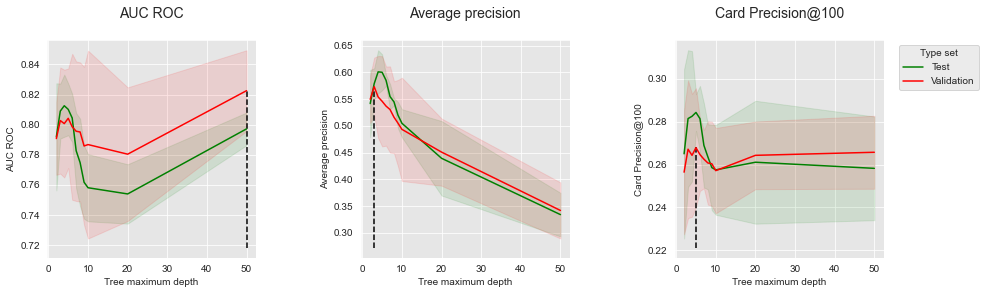

In [20]:
get_performances_plots(performances_df_dt, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       summary_performances=summary_performances_dt)

## Model selection: Exploration of other model classes

This section explores the performances that can be achieved with model selection using other model classes. We cover logistic regression, random forests, and boosting (as in the section [Baseline Fraud Detection System](Baseline_FDS)).


### Logistic regression

The main hyperparameter of logistic regression is the [regularization parameter C](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression). The [default value for this parameter is 1](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression). Let us try fitting models with lower and higher values, for example in the set [0.1,1,10,100].   

In [21]:
classifier = sklearn.linear_model.LogisticRegression()

parameters = {'clf__C':[0.1,1,10,100], 'clf__random_state':[0]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_lr = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[parameters_dict[i]['clf__C'] for i in range(len(parameters_dict))]

# Rename to performances_df_lr for model performance comparison at the end of this notebook
performances_df_lr=performances_df

In [22]:
performances_df_lr

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.866971,0.014856,0.620227,0.015979,0.297143,0.008207,"{'clf__C': 0.1, 'clf__random_state': 0}",0.505353,0.865051,0.009591,0.608326,0.022735,0.278929,0.016300,0.1
1,0.867640,0.015400,0.623075,0.016207,0.297143,0.008806,"{'clf__C': 1, 'clf__random_state': 0}",0.499692,0.866861,0.008988,0.612264,0.023474,0.278214,0.016914,1.0
2,0.867676,0.015412,0.623221,0.016086,0.297500,0.008828,"{'clf__C': 10, 'clf__random_state': 0}",0.511710,0.867050,0.008918,0.612526,0.023715,0.277500,0.016763,10.0
3,0.867676,0.015413,0.623249,0.016076,0.297500,0.008828,"{'clf__C': 100, 'clf__random_state': 0}",0.496295,0.867071,0.008912,0.612537,0.023712,0.277500,0.016763,100.0


The `get_summary_performances` function gives the summary of the best parameters and corresponding performances.

In [23]:
summary_performances_lr=get_summary_performances(performances_df_lr, parameter_column_name="Parameters summary")
summary_performances_lr

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100,100,0.1
Validation performance,0.867+/-0.01,0.613+/-0.02,0.279+/-0.02
Test performance,0.868+/-0.02,0.623+/-0.02,0.297+/-0.01
Optimal parameters,100,100,10
Optimal test performance,0.868+/-0.02,0.623+/-0.02,0.298+/-0.01


Let us plot the performances as a function of the regularization value, together with the value that provides the best estimated performances.  

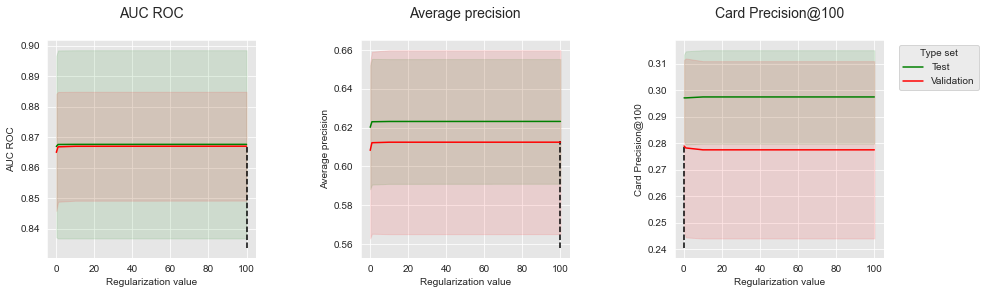

In [24]:
get_performances_plots(performances_df_lr, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Regularization value",
                       summary_performances=summary_performances_lr)

Performances tend to be a bit lower for a low $C$ value (0.1). $C$ values equal or higher than one provide similar performances. The default parameter $C=1$ seems therefore to be a sensible value for the logistic regression model. 

### Random forest

The two main [hyperparameters of a random forest](https://scikit-learn.org/stable/modules/ensemble.html#forest) are the maximum tree depth and the number of trees (parameters `max_depth` and `n_estimators`, respectively). [By default](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), the maximum tree depth is `None` (that is, nodes are expanded until all leaves are pure or until all leaves contain less than `min_samples_split` samples), and the number of trees is 100. Let us try other values, by combining `max_depth` values in the set [5,10,20,50] and `n_estimators` values in the set [25,50,100].

In [25]:
classifier = sklearn.ensemble.RandomForestClassifier()

# Note: n_jobs set to one for getting true execution times
parameters = {'clf__max_depth':[5,10,20,50], 'clf__n_estimators':[25,50,100],
              'clf__random_state':[0],'clf__n_jobs':[1]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_rf = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])
                                   for i in range(len(parameters_dict))]

# Rename to performances_df_rf for model performance comparison at the end of this notebook
performances_df_rf=performances_df


In [26]:
performances_df_rf

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.845289,0.003870,0.620915,0.021970,0.289286,0.010570,"{'clf__max_depth': 5, 'clf__n_estimators': 25,...",1.332392,0.834147,0.009100,0.610413,0.023740,0.274286,0.015551,25/5
1,0.850969,0.007507,0.621135,0.023615,0.290714,0.010996,"{'clf__max_depth': 5, 'clf__n_estimators': 50,...",2.620222,0.844140,0.007473,0.609801,0.027459,0.272857,0.015085,50/5
2,0.855230,0.007315,0.627005,0.021874,0.292500,0.010850,"{'clf__max_depth': 5, 'clf__n_estimators': 100...",5.043742,0.849065,0.011018,0.619450,0.026249,0.275000,0.016614,100/5
3,0.867271,0.006166,0.648592,0.012818,0.300714,0.010950,"{'clf__max_depth': 10, 'clf__n_estimators': 25...",2.537272,0.865000,0.002259,0.651858,0.020059,0.285357,0.012305,25/10
4,0.869225,0.007956,0.655047,0.014188,0.300000,0.012495,"{'clf__max_depth': 10, 'clf__n_estimators': 50...",5.074602,0.871323,0.004542,0.659386,0.021993,0.286786,0.015531,50/10
5,0.874950,0.011903,0.664629,0.014215,0.303214,0.013030,"{'clf__max_depth': 10, 'clf__n_estimators': 10...",8.804179,0.872387,0.005256,0.663483,0.024011,0.286429,0.017627,100/10
6,0.853563,0.014821,0.659957,0.013723,0.296429,0.012016,"{'clf__max_depth': 20, 'clf__n_estimators': 25...",3.257792,0.869822,0.005664,0.680405,0.016982,0.285357,0.014962,25/20
7,0.862639,0.015981,0.673287,0.011435,0.296786,0.013301,"{'clf__max_depth': 20, 'clf__n_estimators': 50...",6.083609,0.876310,0.006773,0.690433,0.019828,0.287143,0.016506,50/20
8,0.870361,0.016913,0.677590,0.011694,0.299286,0.013190,"{'clf__max_depth': 20, 'clf__n_estimators': 10...",13.117394,0.879721,0.006366,0.694251,0.020535,0.288571,0.016690,100/20
9,0.858526,0.008785,0.651904,0.009460,0.296429,0.010996,"{'clf__max_depth': 50, 'clf__n_estimators': 25...",3.690854,0.869955,0.003716,0.674015,0.021355,0.284286,0.016690,25/50


The `get_summary_performances` function gives the summary of the best parameters and corresponding performances.

In [27]:
summary_performances_rf=get_summary_performances(performances_df_rf, parameter_column_name="Parameters summary")
summary_performances_rf

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100/20,100/20,100/20
Validation performance,0.88+/-0.01,0.694+/-0.02,0.289+/-0.02
Test performance,0.87+/-0.02,0.678+/-0.01,0.299+/-0.01
Optimal parameters,100/10,100/20,100/10
Optimal test performance,0.875+/-0.01,0.678+/-0.01,0.303+/-0.01


The best performances are obtained with forests containing 100 trees, with a maximum depth of 10 or 20. The optimal parameters differ from the best estimated parameters for the AUC and CP@100. The difference in terms of performances is however low, and the best estimated parameters can be considered close to the optimal ones.

The visualization of the performances as a function of the model parameters is trickier since two parameters are varied. Let us first fix the number of trees, and then vary the maximum tree depth.

Fixing the number of trees to 100, we get:

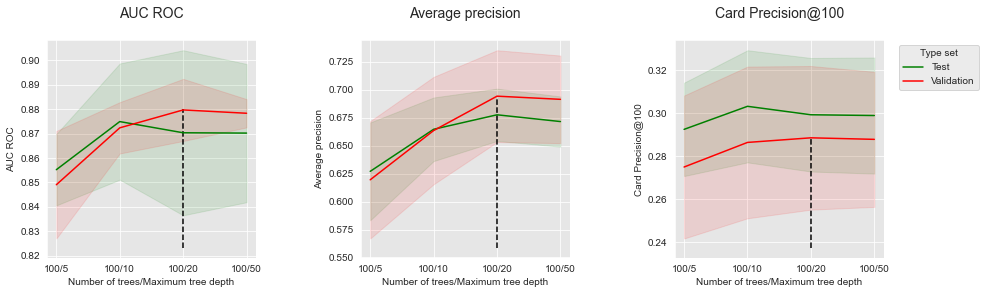

In [28]:
performances_df_rf_fixed_number_of_trees=performances_df_rf[performances_df_rf["Parameters summary"].str.startswith("100")]

summary_performances_fixed_number_of_trees=get_summary_performances(performances_df_rf_fixed_number_of_trees, parameter_column_name="Parameters summary")

get_performances_plots(performances_df_rf_fixed_number_of_trees, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_number_of_trees)

A maximum tree depth of 5 provides the lowest peformances. Performances increase with maximum tree depth, until a tree depth of 10 to 20 where they reach a plateau then slightly decrease. 

Let us then fix the maximum tree depth, and the vary the number of estimators. Fixing the maximum tree depth to 20, we get:

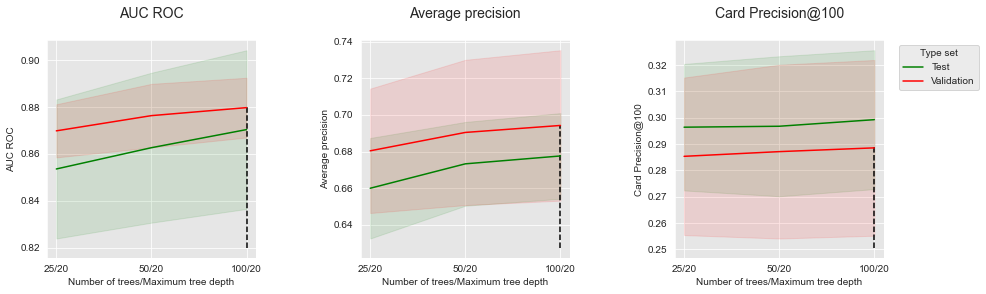

In [29]:
performances_df_rf_fixed_max_tree_depth=performances_df_rf[performances_df_rf["Parameters summary"].str.endswith("20")]

summary_performances_fixed_max_tree_depth=get_summary_performances(performances_df_rf_fixed_max_tree_depth, parameter_column_name="Parameters summary")

get_performances_plots(performances_df_rf_fixed_max_tree_depth, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_max_tree_depth)

For all performance metrics, the common trend is an increase in performances as the number of trees is increased. The added performance gains however decrease with the number of added trees. 

It is worth noting that the execution times for training random forests linearly increases with the number of trees. This can be illustrated by plotting the execution times as a function of the number of trees.

In [30]:
# Get the performance plot for a single performance metric
def get_execution_times_plot(performances_df,
                             title="",
                             parameter_name="Tree maximum depth"):
    
    fig, ax = plt.subplots(1,1, figsize=(5,4))
    
    # Plot data on graph
    ax.plot(performances_df['Parameters summary'], performances_df["Execution time"], 
            color="black")
        
    # Set title, and x and y axes labels
    ax.set_title(title, fontsize=14)
    ax.set(xlabel = parameter_name, ylabel="Execution time (seconds)")

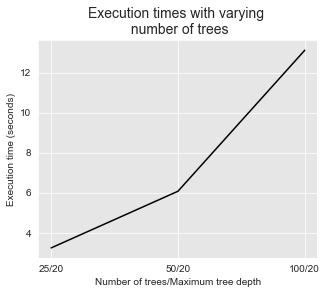

In [31]:
get_execution_times_plot(performances_df_rf_fixed_max_tree_depth, 
                         title="Execution times with varying \n number of trees",
                         parameter_name="Number of trees/Maximum tree depth")

The execution times also increases with the maximum tree depth, as illustrated below. 

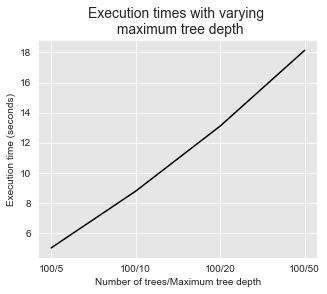

In [32]:
get_execution_times_plot(performances_df_rf_fixed_number_of_trees, 
                         title="Execution times with varying \n maximum tree depth",
                         parameter_name="Number of trees/Maximum tree depth")

All in all, the model selection procedure above took about 10 minutes to complete on one core, although only a small number of parameter combinations were tested (12 in total: 4 different parameters for the maximum tree depth, and 3 different parameters for the number of trees).

In [33]:
print("Total execution time for the model selection procedure: "+str(round(execution_time_rf,2))+"s")

Total execution time for the model selection procedure: 627.54s


This toy example illustrates the trade-off between performance and computation times in the search for optimal parameters. Computational resources are usually constrained, and one must carefully consider which hyperparameter combinations can be tested given the available resources. 

### XGBoost

XGBoost is a powerful learning algorithm whose tuning however relies [on many hyperparameters](https://xgboost.readthedocs.io/en/latest/python/python_api.html). The most important ones are arguably the tree maximum depth (`max_depth`), the number of trees (`n_estimtors`), and the learning rate (`learning_rate`). By default, the maximum tree depth is set to 2, the number of trees to 100, and the learning rate to 0.1. Let us try other combinations, with `max_depth` in the set [2,3,5], `n_estimators` in the set [25,10,100], and `learning_rate` in the set [0.05, 0.1].

In [34]:
classifier = xgboost.XGBClassifier()

parameters = {'clf__max_depth':[2,3,5], 'clf__n_estimators':[25,50,100], 'clf__learning_rate':[0.05, 0.1],
              'clf__random_state':[0], 'clf__n_jobs':[1], 'clf__verbosity':[0]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        n_jobs=1)

execution_time_boosting = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__learning_rate'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])
                                   for i in range(len(parameters_dict))]

# Rename to performances_df_xgboost for model performance comparison at the end of this notebook
performances_df_xgboost=performances_df

In [35]:
performances_df_xgboost

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.804691,0.014233,0.588738,0.027855,0.277143,0.012080,"{'clf__learning_rate': 0.05, 'clf__max_depth':...",1.381555,0.800513,0.014902,0.582041,0.018621,0.263929,0.012263,25/0.05/2
1,0.830872,0.010601,0.622804,0.021647,0.295714,0.015152,"{'clf__learning_rate': 0.05, 'clf__max_depth':...",2.414702,0.815454,0.009721,0.608627,0.021724,0.275357,0.013339,50/0.05/2
2,0.848894,0.011078,0.637512,0.017503,0.299286,0.014304,"{'clf__learning_rate': 0.05, 'clf__max_depth':...",4.477899,0.839563,0.006613,0.628430,0.024998,0.278929,0.013901,100/0.05/2
3,0.820873,0.007643,0.618053,0.020612,0.288929,0.010708,"{'clf__learning_rate': 0.05, 'clf__max_depth':...",1.724567,0.811389,0.011432,0.605400,0.026931,0.271786,0.014441,25/0.05/3
4,0.833103,0.012269,0.636696,0.023064,0.296071,0.014859,"{'clf__learning_rate': 0.05, 'clf__max_depth':...",3.526706,0.828770,0.008527,0.619382,0.025261,0.277857,0.014196,50/0.05/3
5,0.864374,0.006577,0.666651,0.012084,0.302143,0.012717,"{'clf__learning_rate': 0.05, 'clf__max_depth':...",9.786538,0.862599,0.003400,0.651390,0.031014,0.281786,0.014962,100/0.05/3
6,0.828379,0.009684,0.627986,0.020924,0.292143,0.011845,"{'clf__learning_rate': 0.05, 'clf__max_depth':...",2.709496,0.821080,0.012536,0.610315,0.017708,0.275714,0.015320,25/0.05/5
7,0.840545,0.010335,0.636732,0.026156,0.293571,0.013646,"{'clf__learning_rate': 0.05, 'clf__max_depth':...",5.801920,0.831552,0.012443,0.634336,0.028856,0.277500,0.016487,50/0.05/5
8,0.871393,0.016108,0.685460,0.012231,0.303571,0.011451,"{'clf__learning_rate': 0.05, 'clf__max_depth':...",9.421408,0.873190,0.004527,0.693422,0.018965,0.287857,0.015600,100/0.05/5
9,0.830388,0.009841,0.621413,0.021088,0.295714,0.015152,"{'clf__learning_rate': 0.1, 'clf__max_depth': ...",1.321278,0.815454,0.009723,0.608477,0.021612,0.275357,0.013339,25/0.1/2


The `get_summary_performances` function gives the summary of the best parameters and corresponding performances.

In [36]:
summary_performances_xgboost=get_summary_performances(performances_df_xgboost, parameter_column_name="Parameters summary")
summary_performances_xgboost

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100/0.1/5,100/0.1/5,100/0.1/2
Validation performance,0.886+/-0.0,0.707+/-0.02,0.291+/-0.02
Test performance,0.872+/-0.01,0.692+/-0.01,0.304+/-0.01
Optimal parameters,100/0.1/5,100/0.1/3,50/0.1/5
Optimal test performance,0.872+/-0.01,0.694+/-0.01,0.304+/-0.01


The best parameters obtained by validation are the same for ROC AUC, and slightly differ for the average precision and CP@100. The corresponding test performances are however on par.

Let us plot the performances as a function of the maximum tree depth, for a number of trees set to 100. Increasing the maximum tree depth does not clearly affect the performances. It slightly increases performances for AUC ROC and AP, but slightly decreases it for CP@100.

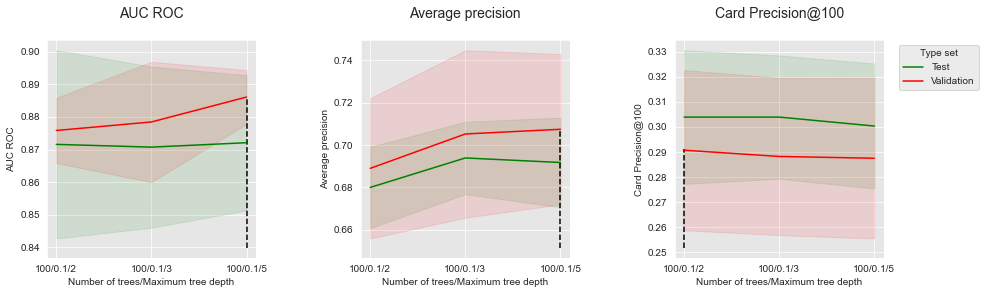

In [37]:
performances_df_xgboost_fixed_number_of_trees=performances_df_xgboost[performances_df_xgboost["Parameters summary"].str.startswith("100/0.1")]

summary_performances_fixed_number_of_trees=get_summary_performances(performances_df_xgboost_fixed_number_of_trees, parameter_column_name="Parameters summary")

get_performances_plots(performances_df_xgboost_fixed_number_of_trees, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_number_of_trees)

Let us then plot the performances as a function of the number of trees, for a maximum tree depth set to 5.

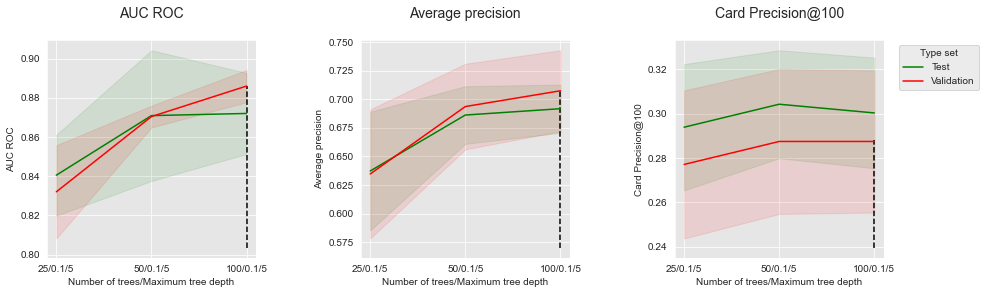

In [38]:
performances_df_xgboost_fixed_max_tree_depth=performances_df_xgboost[performances_df_xgboost["Parameters summary"].str.endswith("0.1/5")]

summary_performances_fixed_max_tree_depth=get_summary_performances(performances_df_xgboost_fixed_max_tree_depth, parameter_column_name="Parameters summary")

get_performances_plots(performances_df_xgboost_fixed_max_tree_depth, 
                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'], 
                       expe_type_list=['Test','Validation'], expe_type_color_list=['#008000','#FF0000'],
                       parameter_name="Number of trees/Maximum tree depth",
                       summary_performances=summary_performances_fixed_max_tree_depth)

Increasing the number of trees from 25 to 50 allow to increase the performances for all performance metrics. Adding more trees however only provides slightly higher performances for AUC ROC and AP, and slightly decreases performances for CP@100. 

Similar to random forests, increasing the maximum tree depth and the number of trees comes at a cost in terms of execution times. This is illustrated in the two figures below.

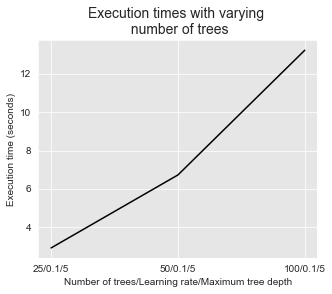

In [39]:
get_execution_times_plot(performances_df_xgboost_fixed_max_tree_depth, 
                         title="Execution times with varying \n number of trees",
                         parameter_name="Number of trees/Learning rate/Maximum tree depth")

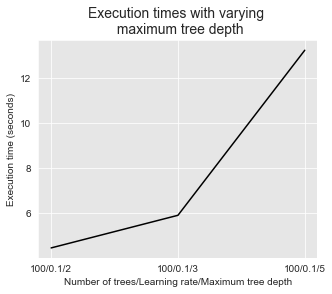

In [40]:
get_execution_times_plot(performances_df_xgboost_fixed_number_of_trees, 
                         title="Execution times with varying \n maximum tree depth",
                         parameter_name="Number of trees/Learning rate/Maximum tree depth")

The total execution time was more than 10 minutes using one core. 

In [41]:
print("Total execution time for the model selection procedure: "+str(round(execution_time_boosting,2))+"s")

Total execution time for the model selection procedure: 666.28s


## Comparison of model performances

The previous section detailed the performances of different model classes. Let us compare these performances in order to determine which model class provides the best performances. 

For each model class, let us retrieve the performance for three types of parameters:

* Default parameters: Default parameters that `sklearn` gives to a model class. The default parameters for each model class are:
    * Decision tree: `max_depth=None`.
    * Logistic regression: `C=1`.
    * Random forest: `n_estimators=100`, `max_depth=None`.
    * XGBoost: `n_estimators=100`, `max_depth=2`, `learning_rate=0.1`.
* Best estimated parameters: Parameters that provide the highest performances on the validation set.
* Optimal parameters: Parameters that provide the highest performances on the test set.

The `model_selection_performances` function below takes a dictionary of performance DataFrames and a performance metric, and retrieves the corresponding performances (mean together with standard deviation). 
 

In [42]:
performances_df_dictionary={
    "Decision Tree": performances_df_dt,
    "Logstic Regression": performances_df_lr,
    "Random Forest": performances_df_rf,
    "XGBoost": performances_df_xgboost
}

In [43]:
def model_selection_performances(performances_df_dictionary,
                                 performance_metric='AUC ROC'):
    
    # Note: max_depth of 50 is similar to None
    default_parameters_dictionary={
        "Decision Tree": 50,
        "Logstic Regression": 1,
        "Random Forest": "100/50",
        "XGBoost": "100/0.1/2"
    }
    
    mean_performances_dictionary={
        "Default parameters": [],
        "Best validation parameters": [],
        "Optimal parameters": []
    }
    
    std_performances_dictionary={
        "Default parameters": [],
        "Best validation parameters": [],
        "Optimal parameters": []
    }
    
    # For each model class
    for model_class, performances_df in performances_df_dictionary.items():
        
        # Get the performances for the default paramaters
        default_performances=performances_df[performances_df['Parameters summary']==default_parameters_dictionary[model_class]]
        default_performances=default_performances.round(decimals=3)
        
        mean_performances_dictionary["Default parameters"].append(default_performances[performance_metric+" Test"].values[0])
        std_performances_dictionary["Default parameters"].append(default_performances[performance_metric+" Test Std"].values[0])
        
        # Get the performances for the best estimated parameters
        performances_summary=get_summary_performances(performances_df, parameter_column_name="Parameters summary")
        mean_std_performances=performances_summary.loc[["Test performance"]][performance_metric].values[0]
        mean_std_performances=mean_std_performances.split("+/-")
        mean_performances_dictionary["Best validation parameters"].append(float(mean_std_performances[0]))
        std_performances_dictionary["Best validation parameters"].append(float(mean_std_performances[1]))
        
        # Get the performances for the boptimal parameters
        mean_std_performances=performances_summary.loc[["Optimal test performance"]][performance_metric].values[0]
        mean_std_performances=mean_std_performances.split("+/-")
        mean_performances_dictionary["Optimal parameters"].append(float(mean_std_performances[0]))
        std_performances_dictionary["Optimal parameters"].append(float(mean_std_performances[1]))
        
    # Return the mean performances and their standard deviations    
    return (mean_performances_dictionary,std_performances_dictionary)

For examples, executing the function for the AUC ROC metric returns:

In [44]:
model_selection_performances(performances_df_dictionary,
                             performance_metric='AUC ROC')

({'Default parameters': [0.797, 0.868, 0.87, 0.872],
  'Best validation parameters': [0.797, 0.868, 0.87, 0.872],
  'Optimal parameters': [0.813, 0.868, 0.875, 0.872]},
 {'Default parameters': [0.005, 0.015, 0.014, 0.014],
  'Best validation parameters': [0.01, 0.02, 0.02, 0.01],
  'Optimal parameters': [0.01, 0.02, 0.01, 0.01]})

For better visualization, let us plot the performances for the four model classes and for each performance metric as bar charts. The implementation is provided with the `get_model_selection_performance_plot` and `get_model_selection_performances_plots` below.

In [45]:
# Get the performance plot for a single performance metric
def get_model_selection_performance_plot(performances_df_dictionary, 
                                         ax, 
                                         performance_metric,
                                         ylim=[0,1]
                                        ):
    
    
    (mean_performances_dictionary,std_performances_dictionary) = \
        model_selection_performances(performances_df_dictionary=performances_df_dictionary,
                                     performance_metric=performance_metric)
    
    
    model_classes=list(performances_df_dictionary.keys())
    
    # width of the bars
    barWidth = 0.3
    # The x position of bars
    r1 = np.arange(len(model_classes))
    r2 = r1+barWidth
    r3 = r1+2*barWidth
    
    # Create Default parameters bars (Orange)
    ax.bar(r1, mean_performances_dictionary['Default parameters'], 
           width = barWidth, color = '#CA8035', edgecolor = 'black', 
           yerr=std_performances_dictionary['Default parameters'], capsize=7, label='Default parameters')
 
    # Create Best validation parameters bars (Red)
    ax.bar(r2, mean_performances_dictionary['Best validation parameters'], 
           width = barWidth, color = '#008000', edgecolor = 'black', 
           yerr=std_performances_dictionary['Best validation parameters'], capsize=7, label='Best validation parameters')

    # Create Optimal parameters bars (Green)
    ax.bar(r3, mean_performances_dictionary['Optimal parameters'], 
           width = barWidth, color = '#2F4D7E', edgecolor = 'black', 
           yerr=std_performances_dictionary['Optimal parameters'], capsize=7, label='Optimal parameters')
 

    # Set title, and x and y axes labels
    ax.set_ylim(ylim[0],ylim[1])
    ax.set_xticks(r2+barWidth/2)
    ax.set_xticklabels(model_classes, rotation = 45, ha="right", fontsize=12)
    ax.set_title(performance_metric+'\n', fontsize=18)
    ax.set_xlabel("Model class", fontsize=16)
    ax.set_ylabel(performance_metric, fontsize=15)

In [46]:
def get_model_selection_performances_plots(performances_df_dictionary, 
                                           performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100']):
    
    # Create as many graphs as there are performance metrics to display
    n_performance_metrics = len(performance_metrics_list)
    fig, ax = plt.subplots(1, n_performance_metrics, figsize=(5*n_performance_metrics,4))
    
    parameter_types=['Default parameters','Best validation parameters','Optimal parameters']
    
    ylim_list=[[0.6,0.9],[0.2,0.8],[0.2,0.35]]
    
    # Plot performance metric for each metric in performance_metrics_list
    for i in range(n_performance_metrics):
    
        get_model_selection_performance_plot(performances_df_dictionary, 
                                             ax[i], 
                                             performance_metrics_list[i],
                                             ylim=ylim_list[i]
                                            )
    
    ax[n_performance_metrics-1].legend(loc='upper left', 
                                       labels=parameter_types, 
                                       bbox_to_anchor=(1.05, 1),
                                       title="Parameter type",
                                       prop={'size': 12},
                                       title_fontsize=12)

    plt.subplots_adjust(wspace=0.5, 
                        hspace=0.8)

This gives:

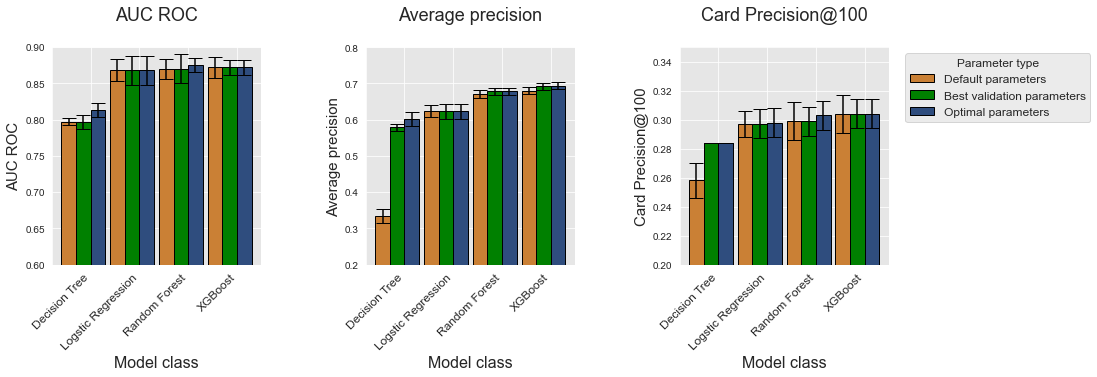

In [47]:
get_model_selection_performances_plots(performances_df_dictionary, 
                                       performance_metrics_list=['AUC ROC', 'Average precision', 'Card Precision@100'])
    

On this simulated dataset, XGBoost provides the highest performances, followed by random forest, logistic regression, and finally decision trees which have the lowest performances. The gap in terms of performance is most visible with the average precision metric. The performances of logistic regression, random forest, and XGBoost are very similar in terms of AUC ROC. 

Let us plot the total execution times of the model selection procedure for each model class.

In [48]:
execution_times=[execution_time_dt,execution_time_lr,
                 execution_time_rf,execution_time_boosting]


In [49]:
%%capture

fig_model_selection_execution_times_for_each_model_class, ax = plt.subplots(1, 1, figsize=(5,4))

model_classes=list(performances_df_dictionary.keys())
    
# width of the bars
barWidth = 0.3
# The x position of bars
r1 = np.arange(len(model_classes))
    
# Create execution times bars
ax.bar(r1, execution_times, 
        width = barWidth, color = 'black', edgecolor = 'black', 
        capsize=7)

ax.set_xticks(r1+barWidth/2)
ax.set_xticklabels(model_classes, rotation = 45, ha="right", fontsize=12)
ax.set_title('Model selection execution times \n for different model classes', fontsize=18)
ax.set_xlabel("Model class", fontsize=16)
ax.set_ylabel("Execution times (s)", fontsize=15)


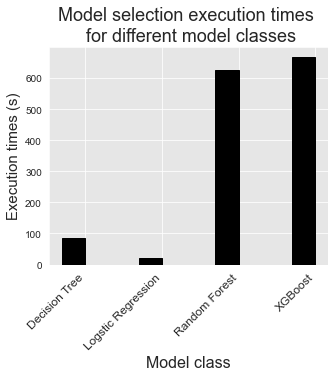

In [66]:
fig_model_selection_execution_times_for_each_model_class

The comparison in terms of execution times is mostly qualitative since they depend to a large extent on the number of parameter combinations that were considered in the model selection procedure. It however illustrates that model selection for complex models such as random forests or boosting usually requires more computational resources, since they require tuning a higher number of hyperparameters. 

## Random search

Grid search is a widely used strategy for hyperparameter optimization. It however quickly becomes intractable when the number of hyperparameters is high since the number of parameter combinations grows exponentially with the number of parameters.

An alternative to grid search is random search, where random combinations of parameters are assessed for a fixed number of combinations. Besides allowing to limit the number of tested parameter combinations, random combinations have been shown both empirically and theoretically to be more efficient for hyperparameter optimization than grid search {cite}`bergstra2012random`. 

The intuition for the efficiency of random search is illustrated in Fig. 3. Essentially, random search allows to more efficiently explore the space of important hyperparameters.   

![alt text](images/random_search.png)
<div align="center">Fig. 3.  Grid and random search of nine parameter combinations, on a two-parameter space. Performance as a function of parameter's values is given in green (top - important parameter) and yellow (left, unimportant parameter). Grid search only assesses the important parameter for three different values, while random search explores the important parameter for nine different values (Figure taken from {cite}`bergstra2012random`).</div>

The implementation of random search in `sklearn` can be performed by relying on `RandomizedSearchCV` instead of `GridSearchCV` in the prequential search. Let us modify the `prequential_grid_search` into a more generic `prequential_parameters_search` function, by adding three new parameters:

* `type_search`: Either 'grid' for grid search, or 'random' for random search.
* `n_iter`: Number of iterations (parameter combinations) for the random search.
* `random_state`: Random state for reproducibility of the random search.


In [57]:
def prequential_parameters_search(transactions_df, 
                            classifier, 
                            input_features, output_feature, 
                            parameters, scoring, 
                            start_date_training, 
                            n_folds=4,
                            expe_type='Test',
                            delta_train=7, 
                            delta_delay=7, 
                            delta_assessment=7,
                            performance_metrics_list_grid=['roc_auc'],
                            performance_metrics_list=['AUC ROC'],
                            type_search='grid',
                            n_iter=10,
                            random_state=0,
                            n_jobs=-1):
    
    estimators = [('scaler', sklearn.preprocessing.StandardScaler()), ('clf', classifier)]
    pipe = sklearn.pipeline.Pipeline(estimators)
    
    prequential_split_indices=prequentialSplit(transactions_df,
                                               start_date_training=start_date_training, 
                                               n_folds=n_folds, 
                                               delta_train=delta_train, 
                                               delta_delay=delta_delay, 
                                               delta_assessment=delta_assessment)
    
    parameters_search = None
    
    if type_search=="grid":
        
        parameters_search = sklearn.model_selection.GridSearchCV(pipe, parameters, scoring=scoring, cv=prequential_split_indices, 
                                         refit=False, n_jobs=n_jobs)
    
    if type_search=="random":
        
        parameters_search = sklearn.model_selection.RandomizedSearchCV(pipe, parameters, scoring=scoring, cv=prequential_split_indices, 
                                     refit=False, n_jobs=n_jobs,n_iter=n_iter,random_state=random_state)

    
    X=transactions_df[input_features]
    y=transactions_df[output_feature]

    parameters_search.fit(X, y)
    
    performances_df=pd.DataFrame()
    
    for i in range(len(performance_metrics_list_grid)):
        performances_df[performance_metrics_list[i]+' '+expe_type]=parameters_search.cv_results_['mean_test_'+performance_metrics_list_grid[i]]
        performances_df[performance_metrics_list[i]+' '+expe_type+' Std']=parameters_search.cv_results_['std_test_'+performance_metrics_list_grid[i]]

    performances_df['Parameters']=parameters_search.cv_results_['params']
    performances_df['Execution time']=parameters_search.cv_results_['mean_fit_time']
    
    return performances_df





In [58]:
def model_selection_wrapper(transactions_df, 
                            classifier, 
                            input_features, output_feature,
                            parameters, 
                            scoring, 
                            start_date_training_for_valid,
                            start_date_training_for_test,
                            n_folds=4,
                            delta_train=7, 
                            delta_delay=7, 
                            delta_assessment=7,
                            performance_metrics_list_grid=['roc_auc'],
                            performance_metrics_list=['AUC ROC'],
                            type_search='grid',
                            n_iter=10,
                            random_state=0,
                            n_jobs=-1):

    # Get performances on the validation set using prequential validation
    performances_df_validation=prequential_parameters_search(transactions_df, classifier, 
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_valid,
                            n_folds=n_folds,
                            expe_type='Validation',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            type_search=type_search,
                            n_iter=n_iter,
                            random_state=random_state,
                            n_jobs=n_jobs)
    
    # Get performances on the test set using prequential validation
    performances_df_test=prequential_parameters_search(transactions_df, classifier, 
                            input_features, output_feature,
                            parameters, scoring, 
                            start_date_training=start_date_training_for_test,
                            n_folds=n_folds,
                            expe_type='Test',
                            delta_train=delta_train, 
                            delta_delay=delta_delay, 
                            delta_assessment=delta_assessment,
                            performance_metrics_list_grid=performance_metrics_list_grid,
                            performance_metrics_list=performance_metrics_list,
                            type_search=type_search,
                            n_iter=n_iter,
                            random_state=random_state,
                            n_jobs=n_jobs)
    
    # Bind the two resulting DataFrames
    performances_df_validation.drop(columns=['Parameters','Execution time'], inplace=True)
    performances_df=pd.concat([performances_df_test,performances_df_validation],axis=1)

    # And return as a single DataFrame
    return performances_df


Let us rerun the model selection for boosting, but using random search, with 10 parameter combinations. 

In [59]:
classifier = xgboost.XGBClassifier()

parameters = {'clf__max_depth':[2,3,5], 'clf__n_estimators':[25,50,100],'clf__learning_rate':[0.05,0.1],
              'clf__random_state':[0],'clf__n_jobs':[1],'clf__n_verbosity':[0]}

start_time=time.time()

performances_df=model_selection_wrapper(transactions_df, classifier, 
                                        input_features, output_feature,
                                        parameters, scoring, 
                                        start_date_training_for_valid,
                                        start_date_training_for_test,
                                        n_folds=n_folds,
                                        delta_train=delta_train, 
                                        delta_delay=delta_delay, 
                                        delta_assessment=delta_assessment,
                                        performance_metrics_list_grid=performance_metrics_list_grid,
                                        performance_metrics_list=performance_metrics_list,
                                        type_search='random',
                                        n_iter=10,
                                        random_state=0,
                                        n_jobs=1)

execution_time_boosting_random = time.time()-start_time

parameters_dict=dict(performances_df['Parameters'])
performances_df['Parameters summary']=[str(parameters_dict[i]['clf__n_estimators'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__learning_rate'])+
                                   '/'+
                                   str(parameters_dict[i]['clf__max_depth'])
                                   for i in range(len(parameters_dict))]

# Rename to performances_df_xgboost_random for model performance comparison
performances_df_xgboost_random=performances_df

In [60]:
performances_df_xgboost_random

,AUC ROC Test,AUC ROC Test Std,Average precision Test,Average precision Test Std,Card Precision@100 Test,Card Precision@100 Test Std,Parameters,Execution time,AUC ROC Validation,AUC ROC Validation Std,Average precision Validation,Average precision Validation Std,Card Precision@100 Validation,Card Precision@100 Validation Std,Parameters summary
0,0.830872,0.010601,0.622804,0.021647,0.295714,0.015152,"{'clf__random_state': 0, 'clf__n_verbosity': 0...",2.743754,0.815454,0.009721,0.608627,0.021724,0.275357,0.013339,50/0.05/2
1,0.828379,0.009684,0.627986,0.020924,0.292143,0.011845,"{'clf__random_state': 0, 'clf__n_verbosity': 0...",3.059411,0.821080,0.012536,0.610315,0.017708,0.275714,0.015320,25/0.05/5
2,0.871393,0.016108,0.685460,0.012231,0.303571,0.011451,"{'clf__random_state': 0, 'clf__n_verbosity': 0...",12.370115,0.873190,0.004527,0.693422,0.018965,0.287857,0.015600,100/0.05/5
3,0.848309,0.010490,0.637862,0.017787,0.299286,0.014304,"{'clf__random_state': 0, 'clf__n_verbosity': 0...",3.169141,0.839086,0.006005,0.628894,0.023866,0.278929,0.015629,50/0.1/2
4,0.870728,0.012343,0.693917,0.008547,0.303929,0.012305,"{'clf__random_state': 0, 'clf__n_verbosity': 0...",8.901414,0.878438,0.009221,0.705235,0.019756,0.288214,0.015694,100/0.1/3
5,0.833103,0.012269,0.636696,0.023064,0.296071,0.014859,"{'clf__random_state': 0, 'clf__n_verbosity': 0...",6.386794,0.828770,0.008527,0.619382,0.025261,0.277857,0.014196,50/0.05/3
6,0.848894,0.011078,0.637512,0.017503,0.299286,0.014304,"{'clf__random_state': 0, 'clf__n_verbosity': 0...",6.957635,0.839563,0.006613,0.628430,0.024998,0.278929,0.013901,100/0.05/2
7,0.870980,0.016694,0.686214,0.012601,0.304286,0.012164,"{'clf__random_state': 0, 'clf__n_verbosity': 0...",6.018764,0.870487,0.002778,0.693645,0.018728,0.287500,0.016331,50/0.1/5
8,0.872081,0.010353,0.691773,0.010572,0.300357,0.012469,"{'clf__random_state': 0, 'clf__n_verbosity': 0...",12.286434,0.886075,0.004126,0.707456,0.017731,0.287500,0.016016,100/0.1/5
9,0.830388,0.009841,0.621413,0.021088,0.295714,0.015152,"{'clf__random_state': 0, 'clf__n_verbosity': 0...",1.876480,0.815454,0.009723,0.608477,0.021612,0.275357,0.013339,25/0.1/2


The `get_summary_performances` function gives the summary of the best parameters and corresponding performances.

In [61]:
summary_performances_xgboost_random=get_summary_performances(performances_df_xgboost_random, parameter_column_name="Parameters summary")
summary_performances_xgboost_random

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100/0.1/5,100/0.1/5,100/0.1/3
Validation performance,0.886+/-0.0,0.707+/-0.02,0.288+/-0.02
Test performance,0.872+/-0.01,0.692+/-0.01,0.304+/-0.01
Optimal parameters,100/0.1/5,100/0.1/3,50/0.1/5
Optimal test performance,0.872+/-0.01,0.694+/-0.01,0.304+/-0.01


The performances are essentially the same as those obtained with the grid search.

In [63]:
# Performances with grid search
summary_performances_xgboost

,AUC ROC,Average precision,Card Precision@100
Best estimated parameters,100/0.1/5,100/0.1/5,100/0.1/2
Validation performance,0.886+/-0.0,0.707+/-0.02,0.291+/-0.02
Test performance,0.872+/-0.01,0.692+/-0.01,0.304+/-0.01
Optimal parameters,100/0.1/5,100/0.1/3,50/0.1/5
Optimal test performance,0.872+/-0.01,0.694+/-0.01,0.304+/-0.01


The execution time was however significantly faster.

In [67]:
print("Total execution time for XGBoost with grid search: "+str(round(execution_time_boosting,2))+"s")
print("Total execution time for XGBoost with random search: "+str(round(execution_time_boosting_random,2))+"s")



Total execution time for XGBoost with grid search: 666.28s
Total execution time for XGBoost with random search: 484.81s
